In [1]:
# set Keras backend to Tensorflow
import os
import tensorflow as tf

os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
# import
import keras
from keras.models import load_model
from keras_adabound import AdaBound
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import pickle
import numpy as np

In [3]:
# make saving directory
saveDir = "./cifar10/combAda/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
# get Cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x train shape:', x_train.shape)
print(x_train.shape[0], 'training images')
print(x_test.shape[0], 'test images')

x train shape: (50000, 32, 32, 3)
50000 training images
10000 test images


In [5]:
from keras.utils import np_utils
# prerequisite
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
initNum = 10000
x_train1 = x_train[:initNum]
y_train1 = y_train[:initNum]
remainXTrain = x_train[initNum:]
remainYTrain = y_train[initNum:]

In [7]:
print("initial training X: {0}\n\
initial training Y: {1}\n\
remaining training X: {2}\n\
remaining training Y: {3}\n\
test X: {4}\n\
test Y: {5}".format(
    x_train1.shape,y_train1.shape,remainXTrain.shape,remainYTrain.shape,x_test.shape,y_test.shape))

initial training X: (10000, 32, 32, 3)
initial training Y: (10000, 10)
remaining training X: (40000, 32, 32, 3)
remaining training Y: (40000, 10)
test X: (10000, 32, 32, 3)
test Y: (10000, 10)


In [8]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [9]:
from keras_adabound import AdaBound

# optimization and compile
def compileModel(model, lr=1e-3, decay=0.1):
    opt = AdaBound(learning_rate=lr, final_lr=decay)

    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
   
    return model

In [10]:
# define layers
def getModel(loadModel=False, modelFilePath="", lr=0.001, decay=1e-6):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model = compileModel(model)
    
    # load model weights if specified
    if loadModel == True:
        model.load_weights(modelFilePath)
    
    return model

In [11]:
# get the newest model file
def getNewestModel(dirname=saveDir):
    import os
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return getModel()
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        return getModel(True, newestModel[0])

In [12]:
# get the CNN model
model = getModel()

In [13]:
# train the model
def trainModel(model, xTrain, yTrain, xTest, yTest, batch_size=50, epochs=100, patience=1):
    es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
    chkpt = os.path.join(saveDir, 'Cifar10_.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # train
    model.fit(xTrain, yTrain,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(xTest, yTest),
              callbacks=[es_cb, cp_cb],
              shuffle=True)
    return model

In [14]:
# run training on the initial dataset

model = trainModel(model, x_train1, y_train1, x_test, y_test, patience=2)


Epoch 1: val_loss improved from inf to 1.77338, saving model to ./cifar10/combAda\Cifar10_.01-2.02-1.77.hdf5

Epoch 2: val_loss improved from 1.77338 to 1.57854, saving model to ./cifar10/combAda\Cifar10_.02-1.68-1.58.hdf5

Epoch 3: val_loss improved from 1.57854 to 1.53942, saving model to ./cifar10/combAda\Cifar10_.03-1.53-1.54.hdf5

Epoch 4: val_loss improved from 1.53942 to 1.38122, saving model to ./cifar10/combAda\Cifar10_.04-1.44-1.38.hdf5

Epoch 5: val_loss improved from 1.38122 to 1.31121, saving model to ./cifar10/combAda\Cifar10_.05-1.36-1.31.hdf5

Epoch 6: val_loss improved from 1.31121 to 1.28456, saving model to ./cifar10/combAda\Cifar10_.06-1.26-1.28.hdf5

Epoch 7: val_loss improved from 1.28456 to 1.19130, saving model to ./cifar10/combAda\Cifar10_.07-1.19-1.19.hdf5

Epoch 8: val_loss did not improve from 1.19130

Epoch 9: val_loss improved from 1.19130 to 1.14315, saving model to ./cifar10/combAda\Cifar10_.09-1.06-1.14.hdf5

Epoch 10: val_loss improved from 1.14315 to

In [18]:
# use the pre-trained model, with 65% accuracy on test data

model.load_weights("./cifar10/combAda\Cifar10_.10-0.98-1.09.hdf5")

In [19]:
# define evaluation method
def evaluate(model, xTest, yTest, display=False):
    # only shows loss and accuracy
    if display == False:
        ev = model.evaluate(xTest, yTest, verbose=0)
        return ev
    # shows confusion matrix, classification report and accuracy score
    else:
        import pandas as pd
        import seaborn as sn
        import matplotlib.pyplot as plt
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report, accuracy_score

        def toNum(y):
            yNum = []
            for x in y:
                yNum.append(x.argmax())
            return np.array(yNum)

        # visualize confusion matrix on heat map
        def print_cmx(y_true, y_pred):
            labels = sorted(list(set(y_true)))
            cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

            df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

            plt.figure(figsize = (10,7))
            sn.heatmap(df_cmx, annot=True)
            plt.show()

        # reshape testing target to fit to scikit-learn metric form
        y_testPred = model.predict(xTest)
        y_testP = toNum(y_testPred)
        y_true = toNum(yTest)

        # get confusion matrix, classification report and accuracy score
        print_cmx(y_true, y_testP)
        print(classification_report(y_true, y_testP))
        print("Accuracy: {0}".format(accuracy_score(y_true, y_testP)))

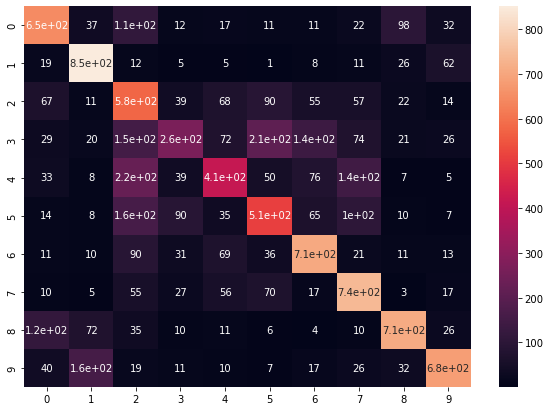

              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1000
           1       0.72      0.85      0.78      1000
           2       0.40      0.58      0.47      1000
           3       0.50      0.26      0.35      1000
           4       0.55      0.41      0.47      1000
           5       0.52      0.51      0.51      1000
           6       0.65      0.71      0.68      1000
           7       0.61      0.74      0.67      1000
           8       0.76      0.71      0.73      1000
           9       0.77      0.68      0.72      1000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.60     10000
weighted avg       0.61      0.61      0.60     10000

Accuracy: 0.6105


In [20]:
# evaluate the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [21]:
# record the loss and accuracy
evalHistory = []
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[1.094157099723816, 0.6104999780654907]


In [22]:
# get a list of low margin inference
def getLowMargin(proba, bound=0.01):
    ls = []
    for i in range(len(proba)):
        margin = proba[i][np.argsort(proba[i])][-1] - proba[i][np.argsort(proba[i])][-2]
        if margin < bound:
            ls.append([i,margin])
    return ls

In [23]:
# get a list of high probability inference
def getHighProb(proba, bound):
    ls = []
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                ls.append([i,p])
    return ls

In [24]:
from keras.utils import np_utils
# concatenate initial training data with low margin of 1st and 2nd choice inference and high probability
# removing them from remaining data
def concatData(proba, remainX, remainY, xTrain, yTrain, Lbound=0.01, Hbound=0.99):
    lm = getLowMargin(proba, Lbound)
    print("number of data with first and second choice probability lower than {0}: {1}".format(Lbound,len(lm)))
    hp = getHighProb(proba, Hbound)
    print("number of data with probability higher than {0}: {1}".format(Hbound,len(hp)))
    
    nlm = np.array(np.array(lm)[:,0], dtype="int32")
    lxAdd = remainX[nlm]
    lyAdd = remainY[nlm]
    print("x shape to be added from low margin: {0}\ny shape to be added: {1}".format(lxAdd.shape, lyAdd.shape))
    
    nhp = np.array(hp)
    hxAdd = remainX[nhp[:,0]]
    hyAdd = np.array([nhp[:,1]]).T
    hyAdd = keras.utils.np_utils.to_categorical(hyAdd, num_classes)
    yActual = remainY[nhp[:,0]]
    print("x shape to be added from high probability: {0}\ny shape to be added: {1}".format(hxAdd.shape, hyAdd.shape))
    
    ixAdd = np.vstack((lxAdd, hxAdd))
    iyAdd = np.vstack((lyAdd, hyAdd))
    nlmhp = np.hstack((nhp[:,0],nlm))
    
    NewXTrain = np.vstack((xTrain, ixAdd))
    NewYTrain = np.vstack((yTrain, iyAdd))
    print("new training data:\n\tx: {0}\n\ty: {1}".format(NewXTrain.shape, NewYTrain.shape))
    
    remainX2 = np.delete(remainX, nlmhp, axis=0)
    remainY2 = np.delete(remainY, nlmhp, axis=0)
    print("remaining data:\n\tx: {0}\n\ty: {1}".format(remainX2.shape, remainY2.shape))
        
    yEval = [[yActual[i],hyAdd[i]] for i in range(len(hyAdd))]
    
    return remainX2, remainY2, NewXTrain, NewYTrain, yEval

In [25]:
def getError(yEval):
    errLabel = [0]*10
    for i in range(len(yEval)):
        if False in (yEval[i][0] == yEval[i][1]):
            errLabel[np.argmax(yEval[i][0]-yEval[i][1])] += 1
    return errLabel

In [26]:
# proba = model.predict_proba(remainXTrain, verbose=0)
proba=model.predict(remainXTrain,verbose=0)

In [27]:
# get new training data from high probability
remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatData(proba, 
                                                                  remainXTrain, 
                                                                  remainYTrain, 
                                                                  x_train1, 
                                                                  y_train1, 
                                                                  0.01,
                                                                  0.9999)
errPred = getError(yEval)

number of data with first and second choice probability lower than 0.01: 783
number of data with probability higher than 0.9999: 88
x shape to be added from low margin: (783, 32, 32, 3)
y shape to be added: (783, 10)
x shape to be added from high probability: (88, 32, 32, 3)
y shape to be added: (88, 10)
new training data:
	x: (10871, 32, 32, 3)
	y: (10871, 10)
remaining data:
	x: (39129, 32, 32, 3)
	y: (39129, 10)


In [28]:
# retrain the model
model = trainModel(model, x_train2, y_train2, x_test, y_test)


Epoch 1: val_loss improved from inf to 1.07431, saving model to ./cifar10/combAda\Cifar10_.01-0.99-1.07.hdf5

Epoch 2: val_loss improved from 1.07431 to 1.06745, saving model to ./cifar10/combAda\Cifar10_.02-0.92-1.07.hdf5

Epoch 3: val_loss improved from 1.06745 to 1.06217, saving model to ./cifar10/combAda\Cifar10_.03-0.87-1.06.hdf5

Epoch 4: val_loss improved from 1.06217 to 1.03544, saving model to ./cifar10/combAda\Cifar10_.04-0.82-1.04.hdf5

Epoch 5: val_loss did not improve from 1.03544
Epoch 5: early stopping


In [29]:
# load the newest checkpoint model to get the best accuracy one
model = getNewestModel()

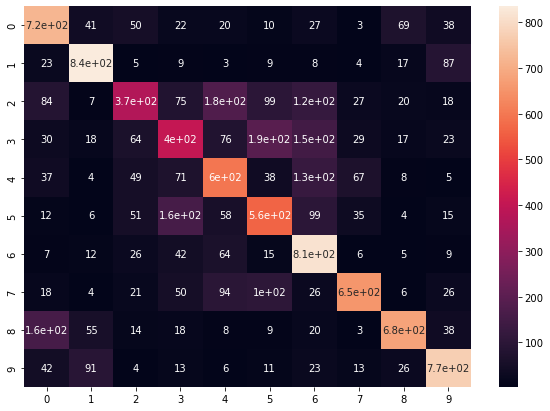

              precision    recall  f1-score   support

           0       0.64      0.72      0.68      1000
           1       0.78      0.83      0.81      1000
           2       0.57      0.37      0.45      1000
           3       0.47      0.40      0.43      1000
           4       0.54      0.59      0.57      1000
           5       0.54      0.56      0.55      1000
           6       0.58      0.81      0.68      1000
           7       0.78      0.65      0.71      1000
           8       0.80      0.68      0.73      1000
           9       0.75      0.77      0.76      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000

Accuracy: 0.6404


In [30]:
# evaluate with the initial test dataset
evaluate(model, x_test, y_test, display=True)

In [31]:
# record the loss and accuracy
evalHistory.append(evaluate(model, x_test, y_test, display=False))
print(evalHistory[-1])

[1.035438060760498, 0.6403999924659729]


In [32]:
for i in range(30):
    #proba = model.predict_proba(remainXTrain, verbose=0)
    proba=model.predict(remainXTrain,verbose=0)
    # get new training data from high probability
    remainXTrain, remainYTrain, x_train2, y_train2, yEval= concatData(proba, 
                                                                      remainXTrain, 
                                                                      remainYTrain, 
                                                                      x_train2, 
                                                                      y_train2, 
                                                                      0.01,
                                                                      0.9999)
    errPred2 = getError(yEval)
    errPred = [errPred2[i]+errPred[i] for i in range(len(errPred))]
    model = trainModel(model, x_train2, y_train2, x_test, y_test)
    model = getNewestModel()
    evalHistory.append(evaluate(model, x_test, y_test, display=False))
    print("\nAfter Iter: {0}\n\tLoss and Acc: {1}\n".format(i,evalHistory[-1]))

number of data with first and second choice probability lower than 0.01: 673
number of data with probability higher than 0.9999: 181
x shape to be added from low margin: (673, 32, 32, 3)
y shape to be added: (673, 10)
x shape to be added from high probability: (181, 32, 32, 3)
y shape to be added: (181, 10)
new training data:
	x: (11725, 32, 32, 3)
	y: (11725, 10)
remaining data:
	x: (38275, 32, 32, 3)
	y: (38275, 10)

Epoch 1: val_loss improved from inf to 0.99540, saving model to ./cifar10/combAda\Cifar10_.01-0.92-1.00.hdf5

Epoch 2: val_loss improved from 0.99540 to 0.98993, saving model to ./cifar10/combAda\Cifar10_.02-0.76-0.99.hdf5

Epoch 3: val_loss did not improve from 0.98993
Epoch 3: early stopping

After Iter: 0
	Loss and Acc: [0.9899290204048157, 0.6611999869346619]

number of data with first and second choice probability lower than 0.01: 542
number of data with probability higher than 0.9999: 281
x shape to be added from low margin: (542, 32, 32, 3)
y shape to be added: (5


Epoch 1: val_loss improved from inf to 0.99854, saving model to ./cifar10/combAda\Cifar10_.01-0.30-1.00.hdf5

Epoch 2: val_loss did not improve from 0.99854
Epoch 2: early stopping

After Iter: 11
	Loss and Acc: [0.9985401630401611, 0.7075999975204468]

number of data with first and second choice probability lower than 0.01: 203
number of data with probability higher than 0.9999: 660
x shape to be added from low margin: (203, 32, 32, 3)
y shape to be added: (203, 10)
x shape to be added from high probability: (660, 32, 32, 3)
y shape to be added: (660, 10)
new training data:
	x: (22986, 32, 32, 3)
	y: (22986, 10)
remaining data:
	x: (27014, 32, 32, 3)
	y: (27014, 10)

Epoch 1: val_loss improved from inf to 0.98828, saving model to ./cifar10/combAda\Cifar10_.01-0.29-0.99.hdf5

Epoch 2: val_loss did not improve from 0.98828
Epoch 2: early stopping

After Iter: 12
	Loss and Acc: [0.9882855415344238, 0.7093999981880188]

number of data with first and second choice probability lower than 0


Epoch 1: val_loss improved from inf to 1.09448, saving model to ./cifar10/combAda\Cifar10_.01-0.22-1.09.hdf5

Epoch 2: val_loss did not improve from 1.09448
Epoch 2: early stopping

After Iter: 23
	Loss and Acc: [1.0944783687591553, 0.7213000059127808]

number of data with first and second choice probability lower than 0.01: 139
number of data with probability higher than 0.9999: 329
x shape to be added from low margin: (139, 32, 32, 3)
y shape to be added: (139, 10)
x shape to be added from high probability: (329, 32, 32, 3)
y shape to be added: (329, 10)
new training data:
	x: (31067, 32, 32, 3)
	y: (31067, 10)
remaining data:
	x: (18933, 32, 32, 3)
	y: (18933, 10)

Epoch 1: val_loss improved from inf to 1.04205, saving model to ./cifar10/combAda\Cifar10_.01-0.21-1.04.hdf5

Epoch 2: val_loss did not improve from 1.04205
Epoch 2: early stopping

After Iter: 24
	Loss and Acc: [1.0420527458190918, 0.7314000129699707]

number of data with first and second choice probability lower than 0